In [233]:
import glob
import pandas as pd
import re
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [20]:
for fi in glob.glob('SRS019*.tar.bz2'):
    print('tar xvf '+fi)

tar xvf SRS019024.tar.bz2
tar xvf SRS019221.tar.bz2
tar xvf SRS019329.tar.bz2


## Build data

In [24]:
fastq = glob.glob('SRS*/*trimmed.1.fastq')
fastq

['SRS016297\\SRS016297.denovo_duplicates_marked.trimmed.1.fastq',
 'SRS016503\\SRS016503.denovo_duplicates_marked.trimmed.1.fastq',
 'SRS017537\\SRS017537.denovo_duplicates_marked.trimmed.1.fastq',
 'SRS018661\\SRS018661.denovo_duplicates_marked.trimmed.1.fastq',
 'SRS019024\\SRS019024.denovo_duplicates_marked.trimmed.1.fastq',
 'SRS019221\\SRS019221.denovo_duplicates_marked.trimmed.1.fastq',
 'SRS019329\\SRS019329.denovo_duplicates_marked.trimmed.1.fastq']

In [3]:
files = glob.glob('RefGenomes/*/*_genomic.fna*')
files[-4:]

['RefGenomes\\[Haemophilus]_parasuis\\GCA_001611775.1_ASM161177v1_cds_from_genomic.fna.gz',
 'RefGenomes\\[Haemophilus]_parasuis\\GCA_001611775.1_ASM161177v1_genomic.fna.gz',
 'RefGenomes\\[Haemophilus]_parasuis\\GCA_001611775.1_ASM161177v1_rna_from_genomic.fna.gz',
 'RefGenomes\\[Haemophilus]_parasuis\\GCA_002055565.1_ASM205556v1_genomic.fna.gz']

In [10]:
rows=[]
tags=[]
for fi in range(len(files)):
    
    path=os.path.abspath( os.path.split(files[fi])[0])
    
    (GenusSpeciesVariant, fna) = files[fi].split(os.path.sep)[-2:]
    
    if re.match('.*from.*', fna):
        continue
    
    #identifier = re.match('(.*\d+.*)_genomic.fna*', fna).group(1)
    identifier = '_'.join(fna.split('_')[0:2])
    
    #os.system()
    tags.append(identifier)
    rows.append( dict(name=GenusSpeciesVariant, fna=fna, tag=identifier, path=path) )

In [ ]:
rows

In [8]:
path

'C:\\Users\\vchaplin\\Documents\\TechChallenge\\Challenge_4\\RefGenomes\\Actinomyces_gaoshouyii'

In [127]:
def datafile2tag(fastq):
    tag = re.match('.*(SRS\d+).*', fastq).group(1)
    return tag

def outfile(tag1,file2, outpath='./'):
    
    tag2=datafile2tag(file2)
    
    output = outpath + tag2 + '/'+tag2+'_'+tag1+'.sam'
    return output
    
def minimap(tag1,file2, outpath='./'):
    output = outfile(tag1,file2,outpath=outpath)

    file1 = df.loc[tag1].path + '/' + df.loc[tag1].fna
    
    return 'minimap2.exe -a '+file1+' '+file2+' > '+output

In [43]:
df = pd.DataFrame(rows,index=tags)

In [128]:
output=[]
for ti in range(len(tags)):
    for di in range(len(fastq)):
        f = minimap(tags[ti], fastq[di], outpath='')+'\n'
        if type(f) != str:
            continue
        f = re.sub('\\\\', '/', f)
        output.append( f )

In [132]:
with open("run_minimap.sh","w") as fh:
    fh.writelines(output)

In [121]:
fh.close()

In [3]:
fastq = glob.glob('SRS*/*singleton*.fastq')
fastq

['SRS016297\\SRS016297.denovo_duplicates_marked.trimmed.singleton.fastq',
 'SRS016503\\SRS016503.denovo_duplicates_marked.trimmed.singleton.fastq',
 'SRS017537\\SRS017537.denovo_duplicates_marked.trimmed.singleton.fastq',
 'SRS018661\\SRS018661.denovo_duplicates_marked.trimmed.singleton.fastq',
 'SRS019024\\SRS019024.denovo_duplicates_marked.trimmed.singleton.fastq',
 'SRS019221\\SRS019221.denovo_duplicates_marked.trimmed.singleton.fastq',
 'SRS019329\\SRS019329.denovo_duplicates_marked.trimmed.singleton.fastq']

# Vectorization


In [33]:
%matplotlib notebook

In [218]:
ref = pd.read_csv('20Randoms5_References_fna.csv', delimiter='\t')
test_frags= ref.columns[1:]
ref_cnts = ref.iloc[1:,1:].as_matrix()
#ref_cnts = np.apply_along_axis(lambda x: x / np.sum(x), 1, ref_cnts.copy() )
#ref_cnts[np.isnan(ref_cnts)]=0


<IPython.core.display.Javascript object>


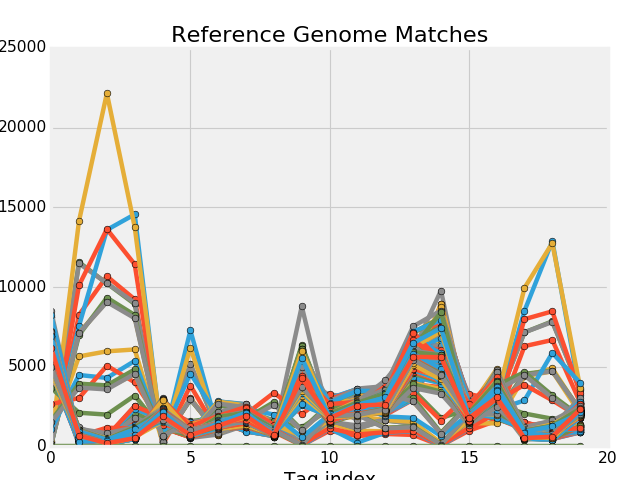

In [238]:
plt.plot(ref_cnts.T,'-o')
plt.title('Reference Genome Matches')
plt.xlabel('Tag index')
plt.ylabel('Count')
plt.savefig('RefTags.png',bbox_inches='tight')

In [220]:
data = pd.read_csv('20Randoms5_Singletons.csv', delimiter='\t')
data_cnts = data.iloc[1:,1:].as_matrix()
#data_cnts = np.apply_along_axis(lambda x: x / np.sum(x), 1, data_cnts.copy() )

<IPython.core.display.Javascript object>


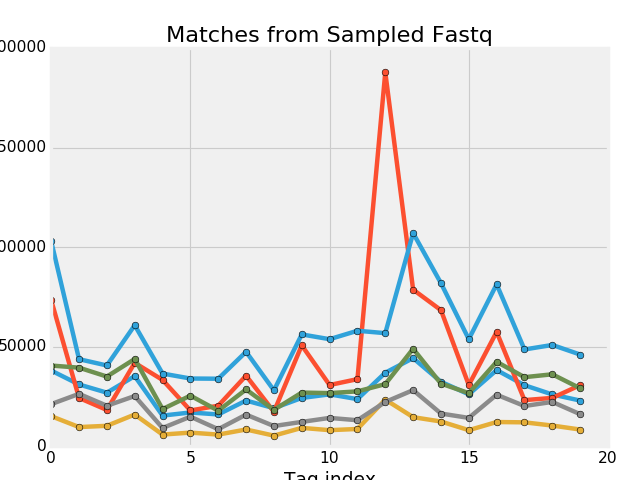

In [237]:
plt.plot(data_cnts.T,'-o')
plt.title('Matches from Sampled Fastq')
plt.xlabel('Tag index')
plt.ylabel('Count')
plt.savefig('DataTags.png',bbox_inches='tight')

In [170]:
np.sum(weights[1:]) / np.sum(weights[:])

0.99519859021576695

In [107]:
import scipy.optimize

In [222]:
#Y_train = data_cnts[0:4,:]
X_train = ref_cnts
def func(weights, data):
    weights = np.ones(X_train.shape[0])
    predicted = weights.dot(X_train)
    
    return np.sum( (predicted - data)**2)
    

In [223]:

weight_avgs = []
Nt=20
for i in range(data_cnts.shape[0]):
    weight1 = np.zeros(X_train.shape[0])
    for k in range(Nt):
        weights0 = np.random.random(size=X_train.shape[0]) 
        ans=scipy.optimize.minimize(func,weights0, args=(data_cnts[i]), method='Nelder-Mead')
        weight1 += ans.x / Nt
    weight_avgs.append(weight1)

In [224]:
weight_avgs = np.array(weight_avgs)
weight_u = np.apply_along_axis(lambda x: x / np.sum(x), 1, weight_avgs )

In [225]:
human = weight_u[:,0]
bact = np.sum(weight_u[:,1:],axis=1)

In [226]:
weight_u 

array([[ 0.00279656,  0.00299698,  0.00328141, ...,  0.0028842 ,
         0.00283863,  0.00343401],
       [ 0.00231368,  0.00289049,  0.00289787, ...,  0.00289341,
         0.00302057,  0.00260048],
       [ 0.00310697,  0.00324706,  0.00367515, ...,  0.00271091,
         0.00284836,  0.00343581],
       [ 0.00320902,  0.00243521,  0.0033762 , ...,  0.00329   ,
         0.00338363,  0.00306893],
       [ 0.00359568,  0.0037698 ,  0.00284292, ...,  0.00339886,
         0.00322574,  0.00379002],
       [ 0.00324022,  0.00378029,  0.00332095, ...,  0.00373233,
         0.00322206,  0.00299227]])

In [240]:
human, bact

(array([ 0.00279656,  0.00231368,  0.00310697,  0.00320902,  0.00359568,
         0.00324022]),
 array([ 0.99720344,  0.99768632,  0.99689303,  0.99679098,  0.99640432,
         0.99675978]))

In [207]:
bact.shape

(6,)

<IPython.core.display.Javascript object>


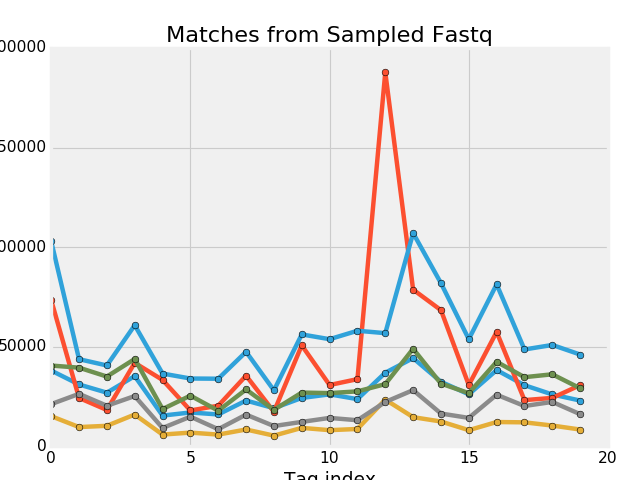

In [239]:
plt.plot(data_cnts.T,'-o')
plt.title('Matches from Sampled Fastq')
plt.xlabel('Tag index')
plt.ylabel('Count')